<a href="https://colab.research.google.com/github/willystumblr/AI-ML_Team_5/blob/kms/nlp/NLP_DT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#python basics
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

#this is just cool
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
from collections import defaultdict
import wordcloud

#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

In [3]:
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nlp-getting-started/test.csv")
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nlp-getting-started/train.csv")

# Data
## What should I expect the data format to be?
Each sample in the train and test set has the following information:

* The `text` of a tweet
* A `keyword` from that tweet (although this may be blank!)
* The `location` the tweet was sent from (may also be blank)

## What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a `1`. If not, predict a `0`.


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
#combine so we work smarter, not harder
total = train_df.append(test_df)

In [7]:
print('There are', len(train_df), 'rows in the train set')
print('There are', len(test_df), 'rows in the test set')

There are 7613 rows in the train set
There are 3263 rows in the test set


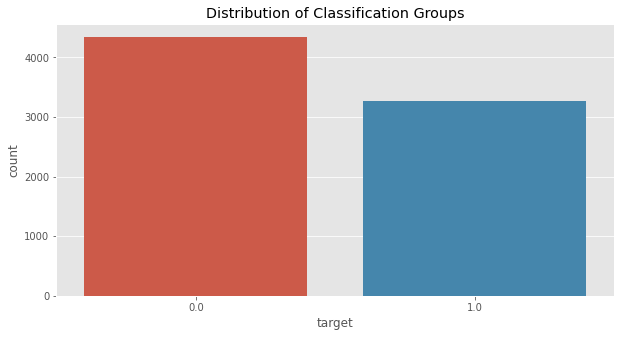

In [8]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = total)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

In [9]:
#save ID
test_id = test_df['id']

#drop from train and test
columns = {'id', 'location'}
train_df = train_df.drop(columns = columns)
test_df = test_df.drop(columns = columns)

#fill missing with unknown
train_df['keyword'] = train_df['keyword'].fillna('unknown')
test_df['keyword'] = test_df['keyword'].fillna('unknown')

#add keyword to tweets
train_df['text'] = train_df['text'] + ' ' + train_df['keyword']
test_df['text'] = test_df['text'] + ' ' + test_df['keyword']

#drop fkeyword rom train and test
columns = {'keyword'}
train_df = train_df.drop(columns = columns)
test_df = test_df.drop(columns = columns)

#combine so we work smarter, not harder
total = train_df.append(test_df)

In [10]:
missing_val = pd.DataFrame(train_df.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,text,0
1,target,0


### Missing values

Very few disaster tweets are less than 50 characters and that the majority of them are more than 125 characters long.

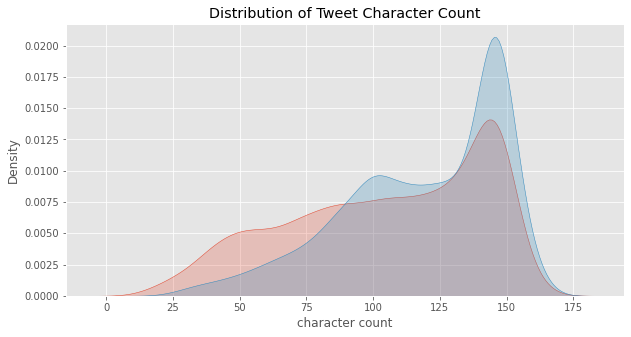

In [11]:
#create column for the number of characters in a tweet
total['character count'] = total['text'].apply(lambda x: len(x))

#split so we can use updated train set with new feature
train_df = total[:len(train_df)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train_df['character count'][train_df['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train_df['character count'][train_df['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Character Count')
plt.show()

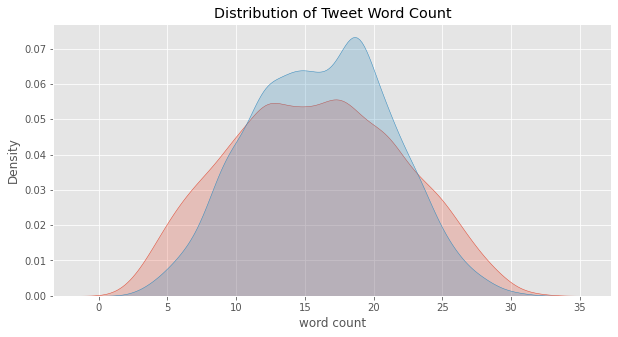

In [12]:
#create column for the number of words in tweet
total['word count'] = total['text'].apply(lambda x: len(x.split()))

#split so we can use updated train set with new feature
train_df = total[:len(train_df)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train_df['word count'][train_df['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train_df['word count'][train_df['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Word Count')
plt.show()

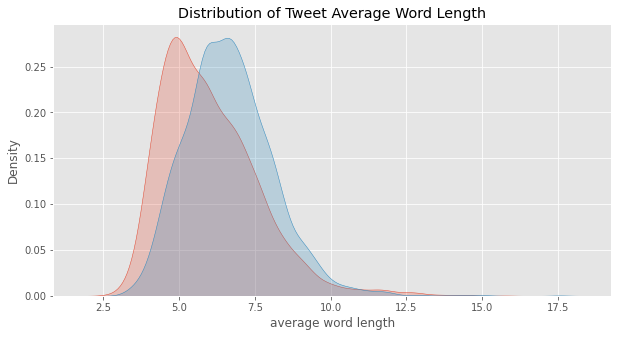

In [13]:
#define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#broadcast to text column
total['average word length'] = total['text'].apply(average_word_length)

#split so we can use updated train set with new feature
train_df = total[:len(train_df)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train_df['average word length'][train_df['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train_df['average word length'][train_df['target'] == 1], shade = True, label = 'Disaster tweet')

#set title
plt.title('Distribution of Tweet Average Word Length')

#splot graphs
plt.show()

## Meta Features
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. **It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies.** Non-disaster tweets **have more typos than disaster tweets because they are coming from individual users**. 

The meta features used for the analysis are;

* `word_count`: number of words in text
* `url_count`: number of urls in text
* `mean_word_length`: average character count in words
* `char_count`: number of characters in text
* `punctuation_count`: number of punctuations in text
* `hashtag_count`: number of hashtags (#) in text
* `mention_count`: number of mentions (@) in text

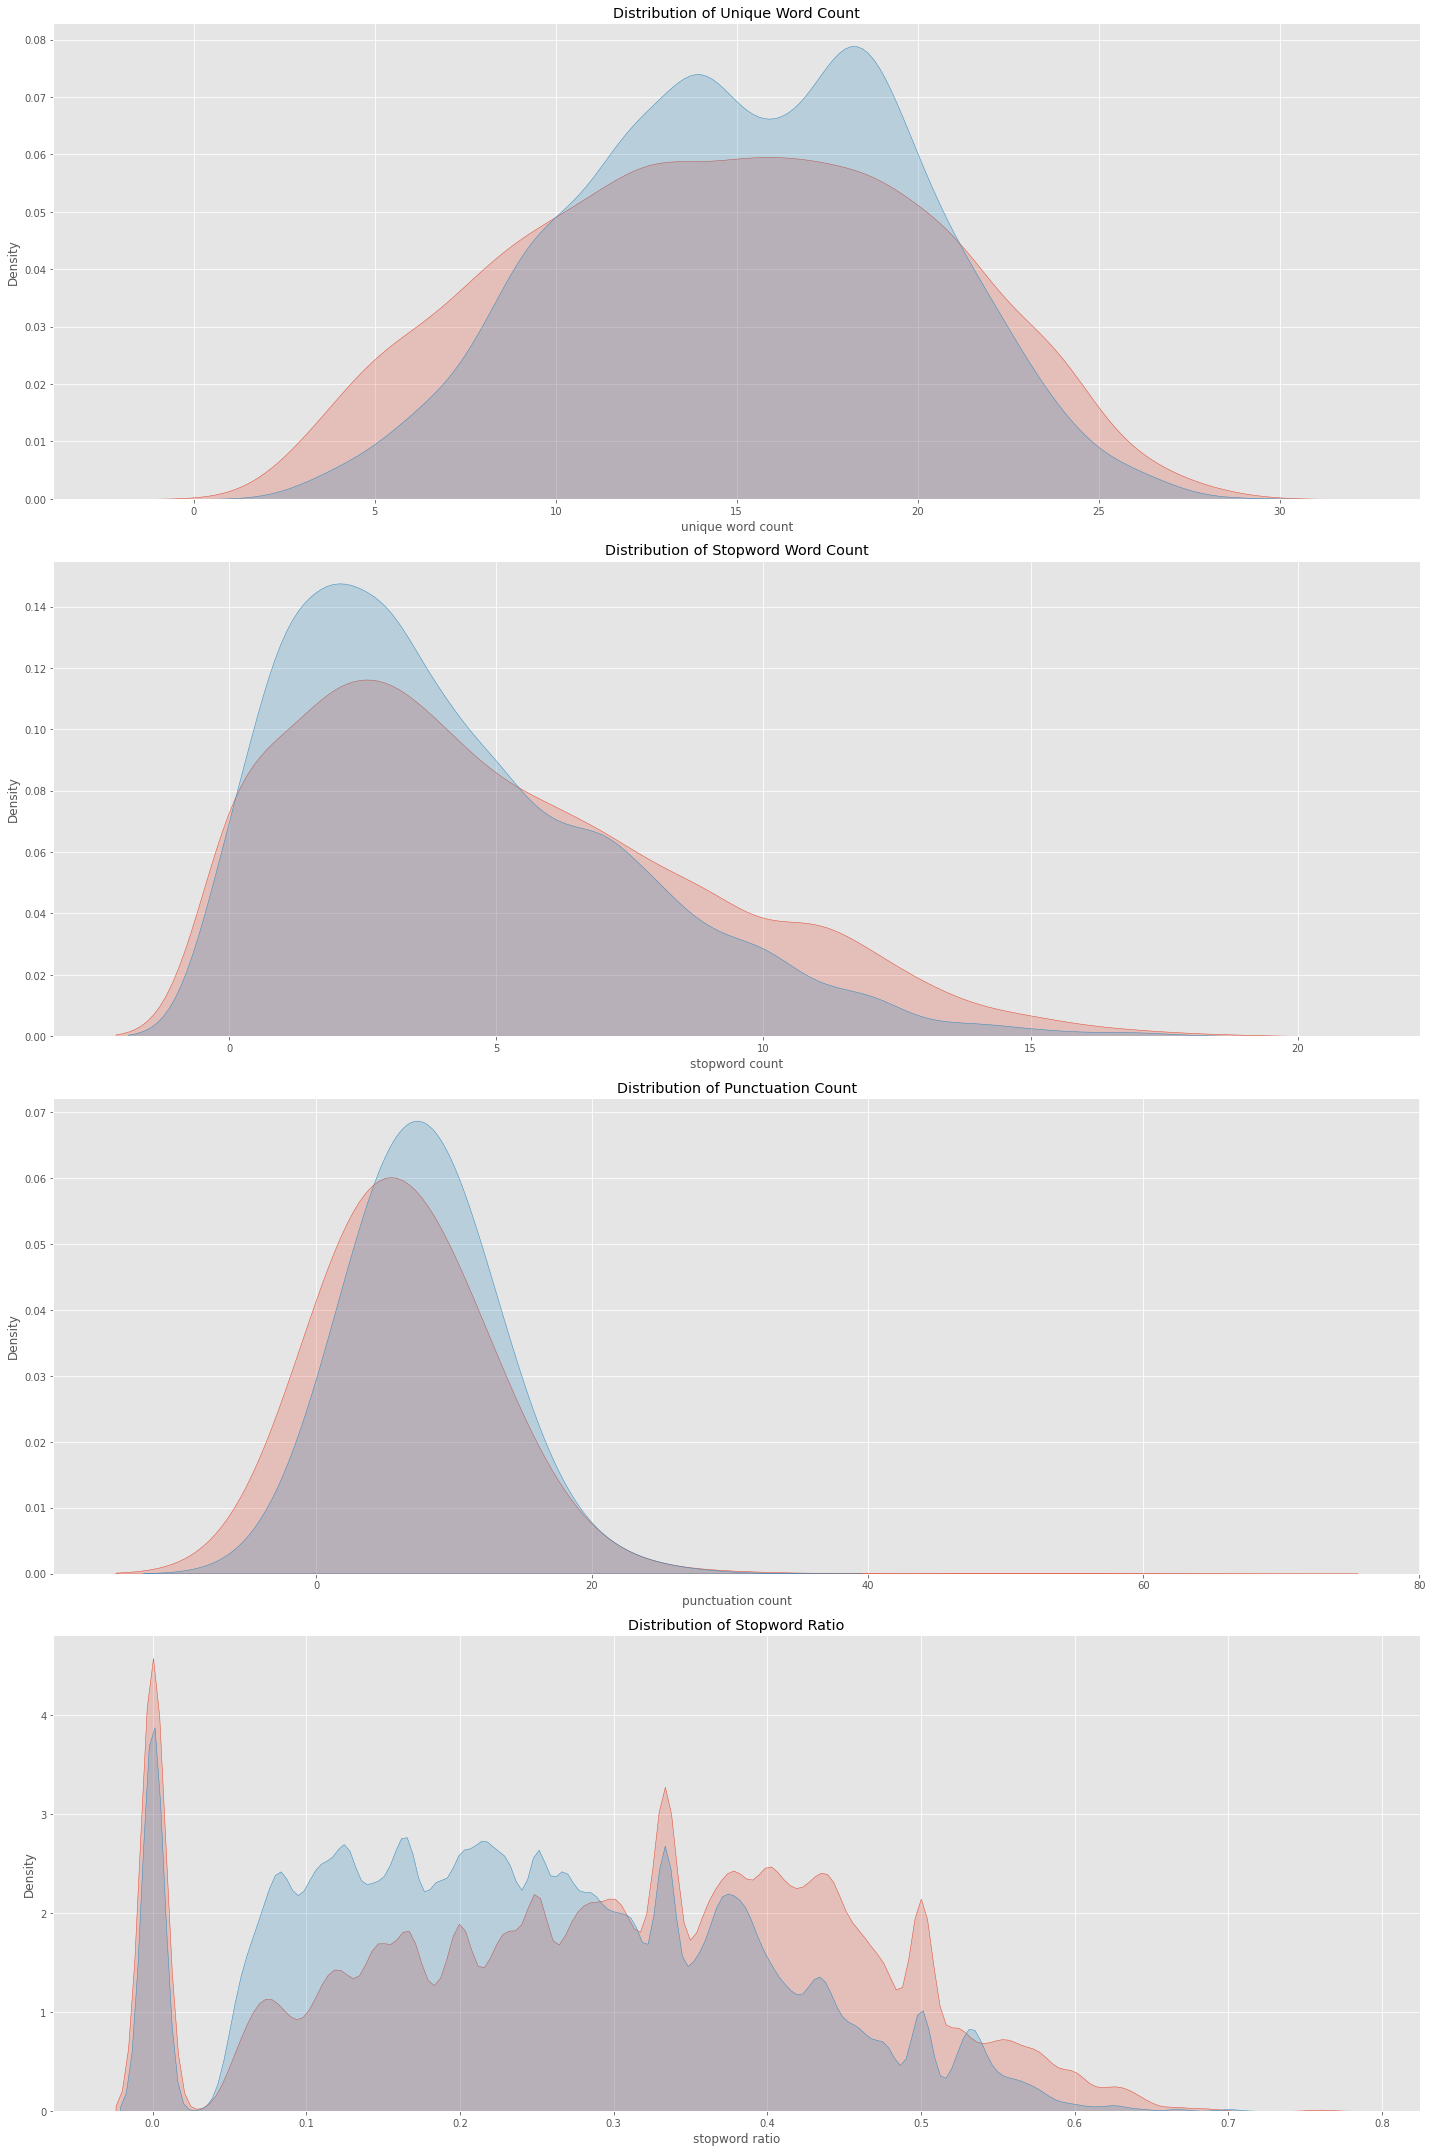

In [14]:
#add unique word count
total['unique word count'] = total['text'].apply(lambda x: len(set(x.split())))

#add stopword count
total['stopword count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

#add url count
#total['url count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

#add mention count
#total['mention count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '@']))

#add hashtag count
#total['hashtag count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '#']))

#add stopword ratio
total['stopword ratio'] = total['stopword count'] / total['word count']

#add punctuation count
total['punctuation count'] = total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#split so we can use updated train set
train_df = total[:len(train_df)]

disaster = train_df['target'] == 1

#produce graphs to visualize newly added features
fig, axes = plt.subplots(4, figsize=(20, 30))

graph1 = sns.kdeplot(train_df.loc[~disaster]['unique word count'], shade = True, label = 'Not Disaster', ax=axes[0])
graph1 = sns.kdeplot(train_df.loc[disaster]['unique word count'], shade = True, label = 'Disaster', ax=axes[0])
graph1.set_title('Distribution of Unique Word Count')

graph2 = sns.kdeplot(train_df.loc[~disaster]['stopword count'], shade = True, label = 'Not Disaster', ax=axes[1])
graph2 = sns.kdeplot(train_df.loc[disaster]['stopword count'], shade = True, label = 'Disaster', ax=axes[1])
graph2.set_title('Distribution of Stopword Word Count')

graph3 = sns.kdeplot(train_df.loc[~disaster]['punctuation count'], shade = True, label = 'Not Disaster', ax=axes[2], bw = 1)
graph3 = sns.kdeplot(train_df.loc[disaster]['punctuation count'], shade = True, label = 'Disaster', ax=axes[2], bw = 1)
graph3.set_title('Distribution of Punctuation Count')

graph4 = sns.kdeplot(train_df.loc[~disaster]['stopword ratio'], shade = True, label = 'Not Disaster', ax=axes[3], bw = .05)
graph4 = sns.kdeplot(train_df.loc[disaster]['stopword ratio'], shade = True, label = 'Disaster', ax=axes[3], bw = .05)
graph4.set_title('Distribution of Stopword Ratio')

fig.tight_layout()
plt.show()

In [15]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [16]:
strip_all_entities('As she gears up for the first night of her Las Vegas residency #PLAY, @katyperry chats with @zanelowe about her new collaboration with @Alesso, “When I’m Gone.”Listen now: http://apple.co/-nmd')

'As she gears up for the first night of her Las Vegas residency PLAY chats with about her new collaboration with When I m Gone Listen now'

Correcting spells


In [17]:
#install autocorrect
!pip install autocorrect
from autocorrect import Speller 

#create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

#showcase spellcheck 
mispelled = 'Pleaze spelcheck this sentince'
spell_check(mispelled)

'Please spelcheck this sentence'

In [18]:
PROCESS_TWEETS = False
if PROCESS_TWEETS:
    #apply all of above functions
    total['text'] = total['text'].apply(lambda x: x.lower())
    total['text'] = total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
    total['text'] = total['text'].apply(remove_punctuation)
    total['text'] = total['text'].apply(remove_stopwords)
    total['text'] = total['text'].apply(remove_less_than)
    total['text'] = total['text'].apply(remove_non_alphabet)
    total['text'] = total['text'].apply(spell_check)

축약하여 쓰는 단어들 다 캐치하기 위해 거치는 작업

Source: [stackoverflow](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [19]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [20]:
total['text'] = total['text'].apply(expand_contractions)

### Cleaning Text
정확한 데이터 처리를 위해 텍스트를 한 번 더 클리닝..

In [21]:
def clean(tweet):

    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    return tweet

total['text'] = total['text'].apply(clean)

### N-Gram Analysis

In [22]:
tweets = [tweet for tweet in total['text']]

#split data to update changes
train_df = total[:len(train_df)]
test_df = total[len(train_df):]

In [23]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in wordcloud.STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

###################################################
#### Trigrams
###################################################

disaster_trigrams = defaultdict(int)
for word in total[train_df['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        disaster_trigrams[word] += 1
disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_trigrams = defaultdict(int)
for word in total[train_df['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        nondisaster_trigrams[word] += 1
nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

###################################################
#### 4-grams
###################################################

disaster_4grams = defaultdict(int)
for word in total[train_df['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        disaster_4grams[word] += 1
disaster_4grams = pd.DataFrame(sorted(disaster_4grams.items(), key=lambda x: x[1])[::-1])

nondisaster_4grams = defaultdict(int)
for word in total[train_df['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        nondisaster_4grams[word] += 1
nondisaster_4grams = pd.DataFrame(sorted(nondisaster_4grams.items(), key=lambda x: x[1])[::-1])

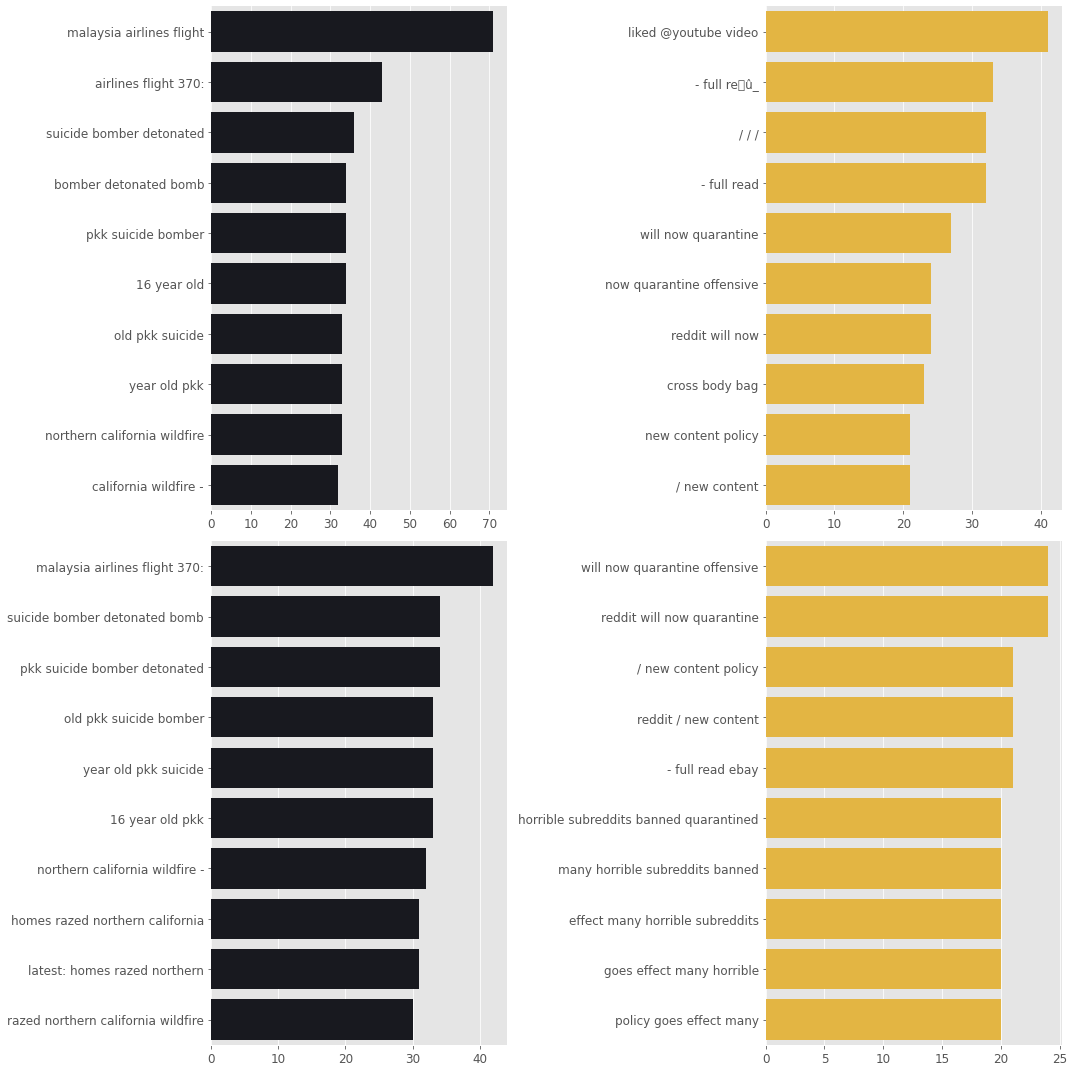

In [24]:
N = 10

fig, ax = plt.subplots(2, 2, figsize = (15, 15))
plt.tight_layout()

sns.barplot(y = disaster_trigrams[0].values[:N], x = disaster_trigrams[1].values[:N], ax = ax[0, 0], color='#171820')
sns.barplot(y = nondisaster_trigrams[0].values[:N], x = nondisaster_trigrams[1].values[:N], ax = ax[0, 1], color = '#fdc029')

sns.barplot(y = disaster_4grams[0].values[:N], x = disaster_4grams[1].values[:N], ax = ax[1, 0], color='#171820')
sns.barplot(y = nondisaster_4grams[0].values[:N], x = nondisaster_4grams[1].values[:N], ax = ax[1, 1], color = '#fdc029')

for i in range(0, 2):
    for j in range(0, 2):
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        ax[i, j].tick_params(axis='x', labelsize=12)
        ax[i, j].tick_params(axis='y', labelsize=12)
    

plt.tight_layout()
plt.show()

### Stopwords
Stopwords are the words in any language which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For some search engines, these are some of the most common, short function words, such as the, is, at, which, and on. In this case, stop words can cause problems when searching for phrases that include them, particularly in names such as “The Who” or “Take That”.

There is no hard and fast rule on when to remove stop words. **But I would suggest removing stop words if our task to be performed is one of Language Classification, Spam Filtering, Caption Generation, Auto-Tag Generation, Sentiment analysis, or something that is related to text classification.**

**Pros and Cons:**

One of the first things that we ask ourselves is what are the pros and cons of any task we perform. Let’s look at some of the pros and cons of stop word removal in NLP.


**pros:**
* Stop words are often removed from the text before training deep learning and machine learning models since stop words occur in abundance, hence providing little to no unique information that can be used for classification or clustering.
* On removing stopwords, dataset size decreases, and the time to train the model also decreases without a huge impact on the accuracy of the model.
* Stopword removal can potentially help in improving performance, as there are fewer and only significant tokens left. Thus, the classification accuracy could be improved


**cons:**
Improper selection and removal of stop words can change the meaning of our text. So we have to be careful in choosing our stop words.

In [25]:
from keras.preprocessing.text import Tokenizer

#find way to tokenize punctuation
to_exclude = '*+-/()%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)
text = 'Why are you so f%#@ing angry all the time?!'
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
tokenizer.fit_on_texts([text])

#view new text
print(tokenizer.word_index)

{'why': 1, 'are': 2, 'you': 3, 'so': 4, 'f': 5, '#': 6, '@': 7, 'ing': 8, 'angry': 9, 'all': 10, 'the': 11, 'time': 12, '?': 13, '!': 14}


In [26]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input

#define tokenizer options
tokenizer = Tokenizer()     
#tokenizer = Tokenizer(oov_token = '<OOV>')           #if you wanted to tokenized OOV words
#tokenizer = Tokenizer(filters = to_exclude)          #if you wanted to include punctuation
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train_df['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train_df)]
labels = labels
nlp_test = data[len(train_df):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 29279 unique tokens.
Shape of data tensor: (10876, 40)
Shape of label tensor: (7613,)


In [27]:
#get GloVe vector embeddings
embeddings_index = {}
with open("/content/drive/MyDrive/Colab Notebooks/nlp-getting-started/glove.6B.200d.txt",'r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asfarray(values[1:])
        embeddings_index[word] = coefs
f.close()

print('\nFound %s word vectors in the GloVe library' % len(embeddings_index))


400000it [00:44, 9080.64it/s] 


Found 400000 word vectors in the GloVe library


In [28]:
EMBEDDING_DIM = 200
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 29279/29279 [00:00<00:00, 459142.57it/s]

Our embedded matrix is of dimension (29280, 200)


In [29]:
#import neural network basic
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, 200, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  

#we do not want embedding layer to train since it has been pretrained

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

#and scal
meta_train = scale(train_df, StandardScaler())
meta_test = scale(test_df, StandardScaler())

In [31]:
#function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [32]:
#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

#and scal
meta_train = scale(train_df, StandardScaler())
meta_test = scale(test_df, StandardScaler())

In [34]:
#create our first model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 200)      5856000     ['nlp_input[0][0]']              
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 40, 200)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 200)          240800      ['spatial_dropout1d[0][0]']  

In [35]:
meta_train.shape

(7613, 7)

In [36]:
#fit model
history1 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 5, batch_size = 21, verbose = 1)

Epoch 1/5
290/290 [==============================] - 52s 162ms/step - loss: 0.5288 - accuracy: 0.7338 - val_loss: 0.4597 - val_accuracy: 0.7925
Epoch 2/5
290/290 [==============================] - 48s 164ms/step - loss: 0.4621 - accuracy: 0.7924 - val_loss: 0.4059 - val_accuracy: 0.8234
Epoch 3/5
290/290 [==============================] - 47s 162ms/step - loss: 0.4382 - accuracy: 0.8038 - val_loss: 0.4052 - val_accuracy: 0.8214
Epoch 4/5
290/290 [==============================] - 50s 173ms/step - loss: 0.4249 - accuracy: 0.8115 - val_loss: 0.4021 - val_accuracy: 0.8227
Epoch 5/5
290/290 [==============================] - 47s 162ms/step - loss: 0.4201 - accuracy: 0.8159 - val_loss: 0.3978 - val_accuracy: 0.8214


In [37]:
history2 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 5, batch_size = 21, verbose = 1)

Epoch 1/5
290/290 [==============================] - 48s 166ms/step - loss: 0.4122 - accuracy: 0.8197 - val_loss: 0.4044 - val_accuracy: 0.8168
Epoch 2/5
290/290 [==============================] - 47s 163ms/step - loss: 0.4019 - accuracy: 0.8278 - val_loss: 0.4002 - val_accuracy: 0.8201
Epoch 3/5
290/290 [==============================] - 46s 160ms/step - loss: 0.3971 - accuracy: 0.8299 - val_loss: 0.4043 - val_accuracy: 0.8194
Epoch 4/5
290/290 [==============================] - 47s 161ms/step - loss: 0.3903 - accuracy: 0.8330 - val_loss: 0.4080 - val_accuracy: 0.8188
Epoch 5/5
290/290 [==============================] - 47s 162ms/step - loss: 0.3840 - accuracy: 0.8363 - val_loss: 0.4119 - val_accuracy: 0.8070


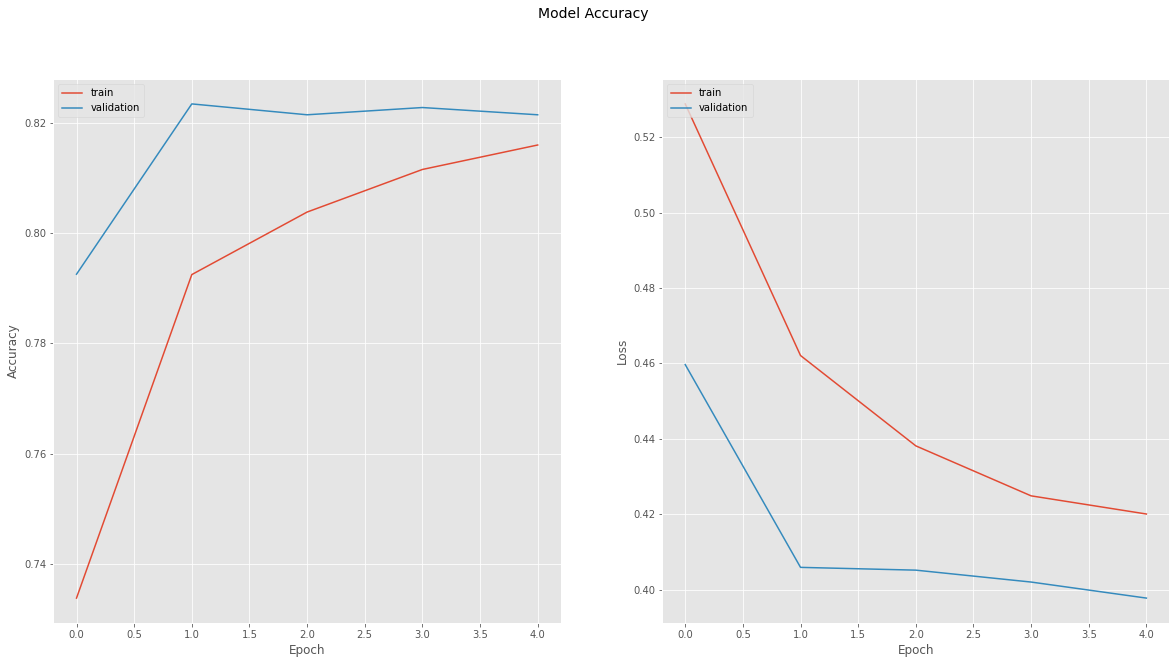

In [38]:
#view model 1 learning curves
plot_learning_curves(history1)

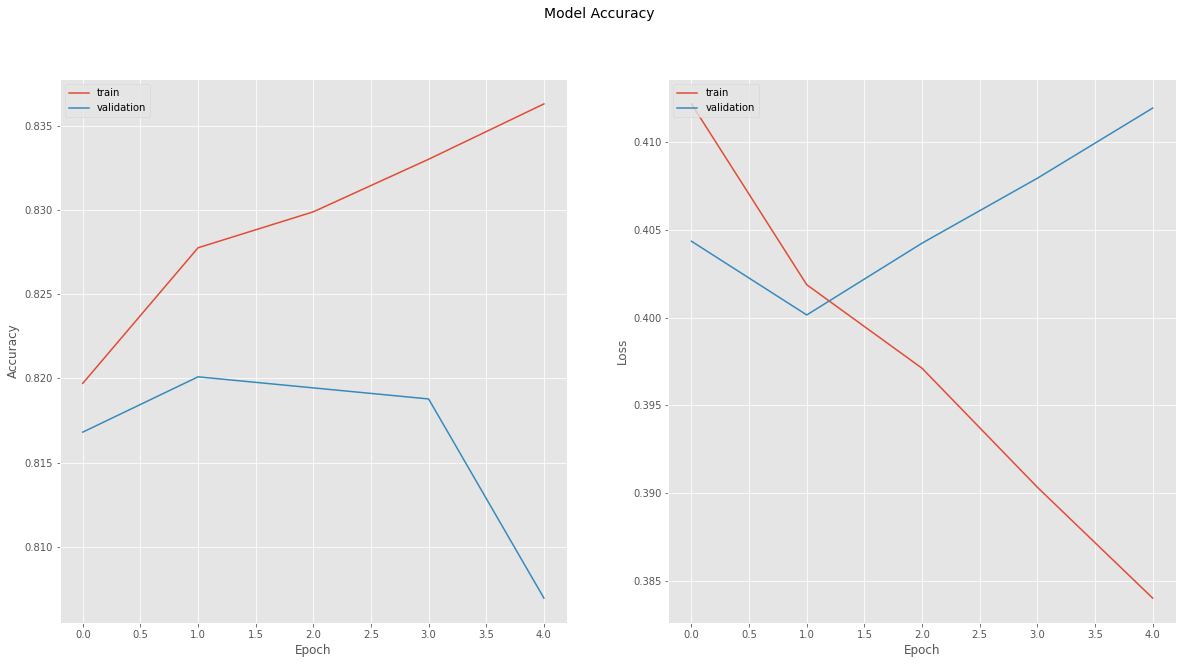

In [39]:
#view model 1 learning curves
plot_learning_curves(history2)

In [40]:
#create submission for complex lstm model
submission_lstm = pd.DataFrame()
submission_lstm['id'] = test_id
submission_lstm['prob'] = lstm.predict([nlp_test, meta_test])
submission_lstm['target'] = submission_lstm['prob'].apply(lambda x: 0 if x < .5 else 1)
submission_lstm.head(10)
submission_lstm.to_csv('submission_lstm.csv', index = False)
print('Blended submission has been saved to disk')

Blended submission has been saved to disk


# BERT

In [1]:
#choose batch size
BATCH_SIZE = 32

#how many epochs?
EPOCHS = 5

#use meta data?
USE_META = True

#add dense layer?
ADD_DENSE = False
DENSE_DIM = 64

#add dropout?
ADD_DROPOUT = False
DROPOUT = .2

In [2]:
!pip install --quiet transformers
#import model and Tokenizer
from transformers import TFAutoModel, AutoTokenizer

In [3]:
#BERT
TOKENIZER = AutoTokenizer.from_pretrained("bert-large-uncased")
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

Encode: [101, 4372, 16044, 2033, 999, 102]
Decode: [CLS] encode me! [SEP]


In [13]:
import numpy as np, pandas as pd
from keras import Input
from tensorflow.keras.optimizers import Adam

In [10]:
import numpy as np
def bert_encode(data,maximum_len) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = TOKENIZER.encode_plus(data.text[i],
                                        add_special_tokens=True,
                                        max_length=maximum_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)


In [14]:
from keras import layers, models, optimizers
def build_model(model_layer, learning_rate, use_meta = USE_META, add_dense = ADD_DENSE,
               dense_dim = DENSE_DIM, add_dropout = ADD_DROPOUT, dropout = DROPOUT):
    
    #define inputs
    input_ids = Input(shape=(60,),dtype='int32')
    attention_masks = Input(shape=(60,),dtype='int32')
    meta_input = Input(shape = (meta_train.shape[1], ))
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    output = transformer_layer[1]
    
    #add meta data
    if use_meta:
        output = layers.Concatenate()([output, meta_input])
    
    #add dense relu layer
    if add_dense:
        print("Training with additional dense layer...")
        output = layers.Dense(dense_dim,activation='relu')(output)
    
    #add dropout
    if add_dropout:
        print("Training with dropout...")
        output = layers.Dropout(dropout)(output)
    
    #add final node for binary classification
    output = layers.Dense(1,activation='sigmoid')(output)
    
    #assemble and compile
    if use_meta:
        print("Training with meta-data...")
        model = models.Model(inputs = [input_ids,attention_masks, meta_input],outputs = output)
    
    else:
        print("Training without meta-data...")
        model = models.Model(inputs = [input_ids,attention_masks],outputs = output)

    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
import pandas as pd
#reimport train and test since we won't be doing any text cleaning
train_DF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp-getting-started/train.csv')
test_DF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp-getting-started/test.csv')

In [15]:
#get BERT layer
bert_large = TFAutoModel.from_pretrained('bert-large-uncased')

#get BERT tokenizer
TOKENIZER = AutoTokenizer.from_pretrained("bert-large-uncased")

#get our inputs
train_input_ids,train_attention_masks = bert_encode(train_DF,60)
test_input_ids,test_attention_masks = bert_encode(test_DF,60)

#debugging step
print('Train length:', len(train_input_ids))
print('Test length:', len(test_input_ids))

#and build and view parameters
BERT_large = build_model(bert_large, learning_rate = 1e-5)
BERT_large.summary()

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length

Train length: 7613
Test length: 3263


NameError: ignored

In [48]:
from keras import callbacks

checkpoint = callbacks.ModelCheckpoint('large_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)


In [49]:
train_DF.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#train BERT
history_bert = BERT_large.fit([train_input_ids,train_attention_masks, meta_train], train_DF.target,
                         validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)

Epoch 1/5


In [ ]:
#load model with best losses
BERT_large.load_weights('large_model.h5')

preds_bert = BERT_large.predict([test_input_ids,test_attention_masks,meta_test])

In [ ]:
#save as dataframe
submission_bert = pd.DataFrame()
submission_bert['id'] = test_id
submission_bert['prob'] = preds_bert
submission_bert['target'] = np.round(submission_bert['prob']).astype(int)
submission_bert = submission_bert[['id', 'target']]
submission_bert.to_csv('submission_bert.csv', index = False)
print('Blended submission has been saved to disk')